# Import libraries

In [1]:
import re 
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from mpl_toolkits.mplot3d import Axes3D  
from statsmodels.tsa.stattools import adfuller, acf  

from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression  
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error, max_error
from catboost import CatBoostRegressor

# utils
- Save photo to computer for better quality: `save_fig`
- Visualize in 2-D and 3-D views with hue: `tsne_visualization` 

In [2]:
def save_fig(file_name):
    plt.savefig(f'D:\\WORKING_ON\\DS\\DAZONE2.2\\{file_name}.png', dpi=300)

# Data Collection 

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))    # print out file paths of files

/kaggle/input/dazone/user_info.csv
/kaggle/input/dazone/user_log.csv
/kaggle/input/dazone/train.csv
/kaggle/input/dazone/test.csv


In [4]:
user_info = pd.read_csv('/kaggle/input/dazone/user_info.csv')
user_info.head()

,user_id,age,sex,phone,job,carrier,marital_status
0,376517,44.0,gentle,******6654,Thực tập sinh giáo dục,other,Married
1,234512,39.0,lady,NaN,NaN,vietnamobile,Married
2,344532,39.0,she,******6296,DevOps Engineer,other,cưới
3,186135,37.0,she,******1502,Thực tập sinh giáo dục,vietnamobile,cưới
4,30230,38.0,female,******4966,DevOps Engineer,viettel,Married


In [5]:
user_log = pd.read_csv('/kaggle/input/dazone/user_log.csv')
user_log.head()

,user_id,item_id,cat_id,brand_id,merchant_id,action,datetime
0,328862,323294,833,2661.0,2882,click,2024-08-29
1,328862,844400,1271,2661.0,2882,click,2024-08-29
2,328862,575153,1271,2661.0,2882,click,2024-08-29
3,328862,996875,1271,2661.0,2882,click,2024-08-29
4,328862,1086186,1271,1049.0,1253,click,2024-08-29


In [6]:
test = pd.read_csv('/kaggle/input/dazone/test.csv')
test.head()

,user_id,merchant_id,label
0,52307,1393,0
1,182730,1890,0
2,92119,423,0
3,339138,4129,0
4,121953,2821,0


In [7]:
train = pd.read_csv('/kaggle/input/dazone/train.csv')
train.head()

,user_id,merchant_id,label
0,393595.0,794.0,0.0
1,287580.0,2447.0,0.0
2,203618.0,598.0,0.0
3,143560.0,2030.0,0.0
4,324173.0,1875.0,0.0


# Data Preprocessing
To make sure data is complete

In [8]:
# source: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :", start_mem_usg, " MB")
    NAlist = []  # Keeps track of columns that have missing values filled in. 
    
    for col in props.columns:
        col_type = props[col].dtype
        
        if col_type == 'object':
            # Skip object types (strings)
            continue
        
        if np.issubdtype(col_type, np.datetime64):
            # Skip datetime columns without changing
            print(f"Skipping datetime column: {col}")
            continue
        
        # Print current column type
        print("******************************")
        print("Column: ", col)
        print("dtype before: ", col_type)
        
        # make variables for Int, max and min
        IsInt = False
        mx = props[col].max()
        mn = props[col].min()
        
        # Integer does not support NA, therefore, NA needs to be filled
        if not np.isfinite(props[col]).all(): 
            NAlist.append(col)
            props[col].fillna(mn-1, inplace=True) 
        
        # test if column can be converted to an integer
        asint = props[col].fillna(0).astype(np.int64)
        result = (props[col] - asint).sum()
        if -0.01 < result < 0.01:
            IsInt = True
        
        # Make Integer/unsigned Integer datatypes
        if IsInt:
            if mn >= 0:
                if mx < 255:
                    props[col] = props[col].astype(np.uint8)
                elif mx < 65535:
                    props[col] = props[col].astype(np.uint16)
                elif mx < 4294967295:
                    props[col] = props[col].astype(np.uint32)
                else:
                    props[col] = props[col].astype(np.uint64)
            else:
                if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                    props[col] = props[col].astype(np.int8)
                elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                    props[col] = props[col].astype(np.int16)
                elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                    props[col] = props[col].astype(np.int32)
                elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                    props[col] = props[col].astype(np.int64)    
        else:
            # Make float datatypes 32 bit
            props[col] = props[col].astype(np.float32)
        
        # Print new column type
        print("dtype after: ", props[col].dtype)
        print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ", mem_usg, " MB")
    print("This is ", 100*mem_usg/start_mem_usg, "% of the initial size")
    
    return props, NAlist


## Table `user_info` 

In [9]:
user_info.isnull().sum()    # check if there is any null values

user_id               0
age               95367
sex                5518
phone             21208
job               21208
carrier           21208
marital_status      357
dtype: int64

Except `user_id`, all other columns contain null. 

`marital_status` and `sex` have the least null values

### **Following are attempts to fill null values and handle inconsistent values:**
- Standardize other columns as much as possible
- Use relations of these columns and null columns to fill null values

#### `marital_status`, `sex`

In [10]:
user_info['marital_status'].value_counts()

marital_status
Married      127517
Single       109226
cưới          95108
ly hôn        31983
Divorced      31891
Unmarried     14049
độc thân      14039
Name: count, dtype: int64

In [11]:
def standardize_marital_status(text):
    '''Standardize martital status into values:
        - "married";
        - "divoirced";
        - "single";
        - "unknown" '''
    
    text = text.lower().strip()
    
    # Tiếng Việt
    if re.search(r'(kết hôn|married|cưới)', text):
        return 'married'
    elif re.search(r'(ly hôn|ly dị|divorced)', text):
        return 'divorced'
    elif re.search(r'(độc thân|single|chưa kết hôn|unmarried)', text):
        return 'single'

In [12]:
# to make sure values in this column are string so that we can apply method from library re
user_info['marital_status'] = user_info['marital_status'].astype(str) 
# 
user_info['marital_status'] = user_info['marital_status'].apply(standardize_marital_status)

In [13]:
# marital_status after standardizing 
user_info['marital_status'].value_counts()

marital_status
married     236674
single      123265
divorced     63874
Name: count, dtype: int64

In [14]:
user_info['sex'].value_counts()

sex
F          47868
lady       47144
girl       47006
she        47004
woman      46806
female     46044
M          20297
boy        20210
men        20081
male       20037
he         19890
gentle     19844
unknown     5532
other       5514
femаle       498
womаn        487
gіrl         487
shе          477
fеmale       461
lаdy         450
femalе       448
wοman        444
hе           203
mеn          201
gеntle       196
gentlе       183
mаle         181
bοy          178
malе         167
othеr         65
սnknown       62
οther         61
unknοwn       57
nսll          53
femаlе         4
fеmаle         4
fеmalе         3
wοmаn          3
mаlе           1
gеntlе         1
Name: count, dtype: int64

In [15]:
sex_mapping = {
    # Female terms
    'lady': 'female',
    'girl': 'female',
    'she': 'female',
    'woman': 'female',
    'female': 'female',
    'F':'female',
    
    
    # Male terms
    'boy': 'male',
    'men': 'male',
    'male': 'male',
    'he': 'male',
    'gentle': 'male',
    'M':'male',
    
    # Unknown/other terms
    'unknown': 'unknown',
    'other': 'unknown',
    'n': 'unknown'  # asssuming 'n' stands for neutral/not specified
}

user_info['sex'] = user_info['sex'].apply(lambda x: sex_mapping.get(str(x).lower()))

In [16]:
# sex after standardizing
user_info['sex'].value_counts()

sex
female     234004
male       100062
unknown     11046
Name: count, dtype: int64

**Now, consider `marital_status`, `sex` to see if they have similarities**

In [17]:
marital_sex = user_info[['marital_status', 'sex']]
print(f'Table user_info has {user_info.shape[0]} rows')
print(f'There are {marital_sex.duplicated().sum()} duplicated rows of marital status and sex')  
marital_sex.head(10)   # print out first 10 rows to ensure the above result

Table user_info has 424170 rows
There are 424154 duplicated rows of marital status and sex


,marital_status,sex
0,married,male
1,married,female
2,married,female
3,married,female
4,married,female
5,married,male
6,married,female
7,married,female
8,single,male
9,single,None


With the above result, we decide to **fill null values of `sex` by mode of `sex` by `marital_status`**

In [18]:
print('Column sex before filling:')
print(user_info['sex'].value_counts())

user_info['sex'] = user_info['sex'].fillna(
    user_info.groupby('marital_status')['sex'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

print('Column sex after filling:')
print(user_info['sex'].value_counts())

Column sex before filling:
sex
female     234004
male       100062
unknown     11046
Name: count, dtype: int64
Column sex after filling:
sex
female     313006
male       100062
unknown     11046
Name: count, dtype: int64


In [19]:
# table user_info after filling values of sex
user_info.isna().sum()

user_id               0
age               95367
sex                  56
phone             21208
job               21208
carrier           21208
marital_status      357
dtype: int64

Then do the same for `marital_status`

In [20]:
print('Column marital_status before filling:')
print(user_info['marital_status'].value_counts())

user_info['marital_status'] = user_info['marital_status'].fillna(
    user_info.groupby('sex')['marital_status'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

print('Column marital_status after filling:')
print(user_info['marital_status'].value_counts())

Column marital_status before filling:
marital_status
married     236674
single      123265
divorced     63874
Name: count, dtype: int64
Column marital_status after filling:
marital_status
married     236975
single      123265
divorced     63874
Name: count, dtype: int64


In [21]:
# table user_info after filling values of marital_status
user_info.isna().sum()

user_id               0
age               95367
sex                  56
phone             21208
job               21208
carrier           21208
marital_status       56
dtype: int64

There are 56 rows where `sex` and `marital_status` were both `NaN`

In [22]:
# delete intermediate dataframe
del marital_sex
import gc
gc.collect()   # freed memory

0

#### Fill `age`, `phone`, `job`, `carrier`
- We cannot guess people's phone number. So that we fill `unknown` for `phone` as value for numbers that missed
- For some reasons, information related to phone wasn't provided, so that for `carrier`, we fill `unknown`
- We categorized `job` into `job_category` then filling its null values with the mode of it groupby its most similar column
- We filled median for numerical column `age`

In [23]:
user_info['phone'] = user_info['phone'].fillna('unknown')    # fill null values of phone by 0

In [24]:
user_info['carrier'] = user_info['carrier'].fillna('unknown')    # # fill null values of carrier by unknown

In [25]:
# table user_info after filling values of phone and carrier
user_info.isna().sum()

user_id               0
age               95367
sex                  56
phone                 0
job               21208
carrier               0
marital_status       56
dtype: int64

Next is attempts for **filling null values of `job`**

Categorize jobs into 7 main catogories based on their income, leisure time, the needs of online buying, etc.: 
1. Technology field: `tech`
2. Managers & Business-related roles: `business`
3. Blue-collar Workers: `blue-collar`
4. Retail & Service roles: `retail and service`
5. Education & Public Sector: `education and public sector`
6. Specialized Professionals: `specialized professional`
7. Others


In [26]:
user_info['job'].value_counts()

job
Chuyên viên nhân sự                 7798
Thợ xây                             7745
Giảng viên                          7745
Công nhân sản xuất                  7731
Nhân Viên Bán Hàng                  7723
DevOps Engineer                     7697
Nhà phân tích dữ liệu               7695
Biên dịch viên                      7694
Nhân viên hành chính                7692
Luật sư                             7674
Tester                              7658
Quản lý sản xuất                    7656
Lập trình viên                      7652
Chuyên viên bảo mật                 7651
Kỹ sư nông nghiệp                   7642
Kiến trúc sư                        7636
Kiến trúc sư phần mềm               7627
Kỹ sư phần mềm                      7627
Nghệ sĩ                             7625
Trưởng phòng kinh doanh             7623
Nhà tư vấn tài chính                7621
Y tá                                7619
Nhà báo                             7618
Kiểm toán                           7617
UX/UI Design

In [27]:
job_mapping = {
    # Technology field
    'DevOps Engineer': 'tech' ,
    'Kỹ sư phần mềm': 'tech',
    'Lập trình viên': 'tech',
    'Tester': 'tech',
    'UX/UI Designer': 'tech',
    'Kiến trúc sư phần mềm': 'tech',
    'Project Manager': 'tech',
    'Chuyên viên nhân sự': 'tech',
    'Chuyên viên bảo mật': 'tech',
    'Nhà phân tích dữ liệu': 'tech',
    'Chuyên viên phân tích thị trường': 'tech',
    'Nhà thiết kế đồ họa': 'tech',

    # Manager and Business-related roles 
    'Giám đốc kinh doanh': 'business',
    'Trưởng phòng kinh doanh': 'business',
    'Quản lý sản xuất': 'business',
    'Marketing Manager': 'business',
    'Nhà tư vấn tài chính': 'business',
    'Chuyên viên tín dụng': 'business',
    'Chuyên viên nhân sự': 'business',
    'Digital Marketer': 'business',

    # blue-collar workers
    'Công nhân sản xuất': 'blue-collar',
    'Thợ xây': 'blue-collar',
    'Nông dân': 'blue-collar',

    # specialized professionals
    'Bác sĩ': 'specialized professional',
    'Y tá': 'specialized professional',
    'Điều Dưỡng': 'specialized professional',
    'Dược sĩ': 'specialized professional',
    'Luật sư': 'specialized professional',
    'Nhà báo': 'specialized professional',
    'Nghệ sĩ': 'specialized professional',
    'Kiểm toán': 'specialized professional',
    'Kế toán': 'specialized professional',
    'Kỹ sư nông nghiệp': 'specialized professional',
    'Kiến trúc sư': 'specialized professional',
    'Kỹ sư xây dựng': 'specialized professional',
    'Kỹ sư giám sát': 'specialized professional',
    'Kỹ sư sản xuất': 'specialized professional',

    # retail and service
    'Nhân Viên Bán Hàng': 'retail and service',
    'Sales Representative': 'retail and service',
    'Tư vấn khách hàng': 'retail and service',
    'Nhân viên kinh doanh': 'retail and service',
    'Chuyên viên bán hàng trực tuyến': 'retail and service',
    'Nhân viên ngân hàng': 'retail and service',
    'Nhân viên nhà hàng': 'retail and service',
    'Nhân viên khách sạn': 'retail and service',
    'Nhân viên lễ tân': 'retail and service',
    'Nhân viên hành chính': 'retail and service',
    'Thư ký pháp lý': 'retail and service',

    # education and publicator
    'Giáo viên': 'education and publicator',
    'Giảng viên': 'education and publicator',
    'Thực tập sinh giáo dục': 'education and publicator',
    'Thực tập': 'education and publicator',
    'Chuyên viên tư vấn tuyển sinh': 'education and publicator',
    'Biên dịch viên': 'education and publicator',

    # others
    'others': 'others',
    'Thực Tập': 'others'

}

# using job_mapping to categorize jobs 
user_info['job_category'] = user_info['job'].apply(lambda x: job_mapping.get(str(x)))

**Now, consider `job_category`, `marital_status`, `sex`, `carrier` to see if they have similarities**

In [28]:
job_marital_sex_carrier = user_info[['job_category', 'marital_status', 'sex', 'carrier']]
print(f'Table user_info has {user_info.shape[0]} rows')
print(f'There are {job_marital_sex_carrier.duplicated().sum()} duplicated rows of job_category, marital status, sex and carrier')  
job_marital_sex_carrier.head(10)   # print out first 10 rows to ensure the above result

Table user_info has 424170 rows
There are 423709 duplicated rows of job_category, marital status, sex and carrier


,job_category,marital_status,sex,carrier
0,education and publicator,married,male,other
1,None,married,female,vietnamobile
2,tech,married,female,other
3,education and publicator,married,female,vietnamobile
4,tech,married,female,viettel
5,tech,married,male,vinaphone
6,tech,married,female,vietnamobile
7,business,married,female,mobiphone
8,tech,single,male,vinaphone
9,tech,single,female,unknown


With the above result, we decide to **fill null values of `job_category` by mode of `job_category` by `sex`**

In [29]:
print('Column job_category before filling:')
print(user_info['job_category'].value_counts())

user_info['job_category'] = user_info['job_category'].fillna(
    user_info.groupby('sex')['job_category'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

print('\nColumn job_category after filling:')
print(user_info['job_category'].value_counts())

Column job_category before filling:
job_category
specialized professional    106251
tech                         83854
retail and service           83117
business                     60961
education and publicator     38177
blue-collar                  23008
others                        7594
Name: count, dtype: int64

Column job_category after filling:
job_category
specialized professional    127457
tech                         83854
retail and service           83117
business                     60961
education and publicator     38177
blue-collar                  23008
others                        7594
Name: count, dtype: int64


In [30]:
# table user_info after filling values of job_category
user_info.isna().sum()

user_id               0
age               95367
sex                  56
phone                 0
job               21208
carrier               0
marital_status       56
job_category          2
dtype: int64

In [31]:
# delete intermediate dataframe
del job_marital_sex_carrier
import gc
gc.collect()   # freed memory

0

#### `age`

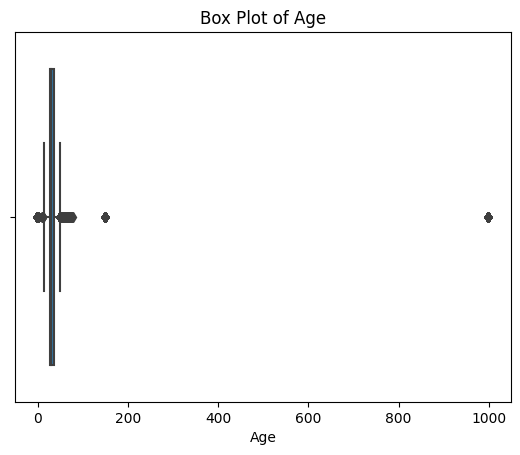

In [32]:
sns.boxplot(x=user_info['age'])

plt.title("Box Plot of Age")
plt.xlabel("Age")
plt.show()

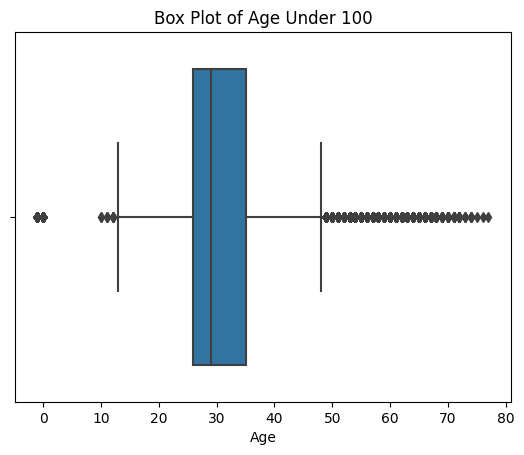

In [33]:
sns.boxplot(x=user_info['age'][user_info['age'] <= 100])

plt.title("Box Plot of Age Under 100")
plt.xlabel("Age")
plt.show()

Obviously, there are noises which are greater than 100
Lét's have a closer look of the range from 0 to 100 

In [34]:
user_info['age'].describe()

count    328803.000000
mean         32.064674
std          32.842554
min          -1.000000
25%          26.000000
50%          29.000000
75%          35.000000
max         999.000000
Name: age, dtype: float64

Compare 2 box plots and the describe table, we **fill null values and noise of `age` with its median or Q2 (29)**

In [35]:
# Define noise condition for age
noise_condition = (user_info['age'] < 0) | (user_info['age'] > 100)

# Fill null values by median
user_info['age'] = user_info['age'].fillna(user_info['age'].median())

# Fill noises by median
user_info.loc[noise_condition, 'age'] = user_info['age'].median()

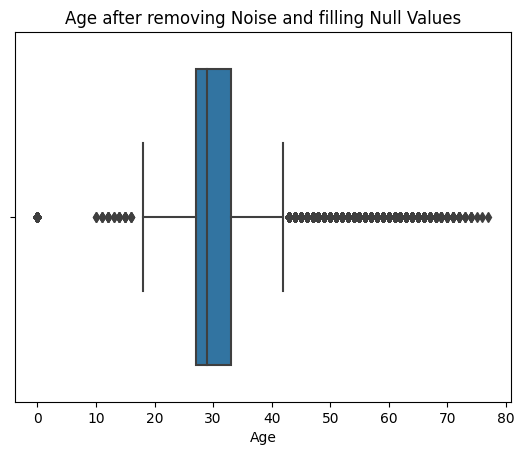

In [36]:
sns.boxplot(x=user_info['age'])

plt.title("Age after removing Noise and filling Null Values")
plt.xlabel("Age")
plt.show()

In [37]:
# table user_info after filling values of age
user_info.isna().sum()

user_id               0
age                   0
sex                  56
phone                 0
job               21208
carrier               0
marital_status       56
job_category          2
dtype: int64

- For the amount of null values of `sex` and `marital_status` is very small comparing to the size of `user_info`, we decide to delete these 56 rows
- `job` will not be used anymore as we will use `job

In [38]:
# remove job, phone column from user_info 
# to make sure there's only NaN values at marital_status and sex
user_info = user_info.drop(columns=['job','phone'], axis=1)    
# remove NaN rows
user_info = user_info.dropna()

In [39]:
# user_info after drop NaN values 
user_info.shape

(424114, 6)

We check if there is still inconsistent values 

In [40]:
for column in user_info.columns:
    print('\nColumn: ', column)
    print(user_info[column].value_counts())


Column:  user_id
user_id
376517    1
298563    1
60770     1
406583    1
30706     1
         ..
311878    1
320271    1
134907    1
235690    1
18031     1
Name: count, Length: 424114, dtype: int64

Column:  age
age
29.0    112482
26.0     25599
27.0     25497
25.0     22035
28.0     21853
         ...  
13.0         2
10.0         2
75.0         1
76.0         1
77.0         1
Name: count, Length: 68, dtype: int64

Column:  sex
sex
female     313006
male       100062
unknown     11046
Name: count, dtype: int64

Column:  carrier
carrier
other           80797
mobiphone       80738
vinaphone       80722
viettel         80415
vietnamobile    80238
unknown         21204
Name: count, dtype: int64

Column:  marital_status
marital_status
married     236975
single      123265
divorced     63874
Name: count, dtype: int64

Column:  job_category
job_category
specialized professional    127445
tech                         83842
retail and service           83106
business                     6095

### Check duplicates

In [41]:
user_info.duplicated().sum()

0

### Check data type

In [42]:
user_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 424114 entries, 0 to 424169
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         424114 non-null  int64  
 1   age             424114 non-null  float64
 2   sex             424114 non-null  object 
 3   carrier         424114 non-null  object 
 4   marital_status  424114 non-null  object 
 5   job_category    424114 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 22.7+ MB


All columns have the type `object` are categorical data which would be encoded later. So that we didn't convert them into string or other types 

In [43]:
# reduce unecessary memory of user_info
user_info, NAlist = reduce_mem_usage(user_info)

Memory usage of properties dataframe is : 22.650131225585938  MB
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  age
dtype before:  float64
dtype after:  uint8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  18.200998306274414  MB
This is  80.35714285714286 % of the initial size


## Table `user_log`

In [44]:
user_log.isnull().sum()

user_id            0
item_id            0
cat_id             0
brand_id       91015
merchant_id        0
action             0
datetime           0
dtype: int64

In [45]:
# check if there is any column similar to brand_id
brand_cat_item_merchant_user = user_log[['brand_id', 'cat_id', 'item_id', 'user_id']]
print(f'Table user_log has {user_log.shape[0]} rows')
print(f'There are {brand_cat_item_merchant_user.duplicated().sum()}\
    duplicated rows of brand, category, item, merchant and user')  

# print out first 10 rows to ensure the above results
brand_cat_item_merchant_user.head(10) 

Table user_log has 54925330 rows
There are 22828517    duplicated rows of brand, category, item, merchant and user


,brand_id,cat_id,item_id,user_id
0,2661.0,833,323294,328862
1,2661.0,1271,844400,328862
2,2661.0,1271,575153,328862
3,2661.0,1271,996875,328862
4,1049.0,1271,1086186,328862
5,2661.0,1271,623866,328862
6,2661.0,1467,542871,328862
7,1647.0,1095,536347,328862
8,2661.0,1271,364513,328862
9,2661.0,1271,575153,328862


In [46]:
# check if which in above 3 columns (except brand_id)
# has a similar value distribution as brand_id (using percentage)
for col in brand_cat_item_merchant_user:
    print(f'\n{brand_cat_item_merchant_user[col].value_counts(normalize=True)}')


brand_id
3738.0    1.392094e-02
1360.0    1.345043e-02
1446.0    1.330472e-02
1214.0    9.867453e-03
5376.0    9.629062e-03
              ...     
124.0     1.823676e-08
1293.0    1.823676e-08
1515.0    1.823676e-08
3443.0    1.823676e-08
3392.0    1.823676e-08
Name: proportion, Length: 8443, dtype: float64

cat_id
662     7.899862e-02
737     3.185694e-02
1505    3.139242e-02
389     2.952619e-02
656     2.801929e-02
            ...     
899     1.820654e-08
334     1.820654e-08
920     1.820654e-08
1045    1.820654e-08
275     1.820654e-08
Name: proportion, Length: 1658, dtype: float64

item_id
67897      6.297732e-03
783997     3.240854e-03
636863     1.501675e-03
631714     7.787118e-04
61518      6.336057e-04
               ...     
491529     1.820654e-08
253476     1.820654e-08
764848     1.820654e-08
1033474    1.820654e-08
390539     1.820654e-08
Name: proportion, Length: 1090390, dtype: float64

user_id
254263    2.634122e-04
276887    2.158567e-04
109251    1.670086e-04
231

In [47]:
del brand_cat_item_merchant_user
gc.collect()    # freed memory

6012

With the above results, we decided to **fill null values of `brand_id` by mode of `brand_id` by `cat_id`**

In [48]:
# fill null values for brand_id
user_log['brand_id'] = user_log['brand_id'].fillna(
    user_log.groupby('cat_id')['brand_id'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [49]:
user_log.isna().sum()

user_id           0
item_id           0
cat_id            0
brand_id       2352
merchant_id       0
action            0
datetime          0
dtype: int64

There're still null values of `brand_id` which is a very small portion of the whole `user_log`.
So that, we decided to drop these rows.

In [50]:
user_log = user_log.dropna()

In [51]:
print(f'Size of user_log after handling missing values: {user_log.shape}')

Size of user_log after handling missing values: (54922978, 7)


### Check inconsistent values and data type

In [52]:
user_log.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54922978 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   brand_id     float64
 4   merchant_id  int64  
 5   action       object 
 6   datetime     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.3+ GB


- `action` would be encoded later so we didn't convert it into string or other types
- Convert `datetime` to type datetime

In [53]:
# convert `datetime` to type datetime
user_log['datetime'] = pd.to_datetime(user_log['datetime'])

In [54]:
# reduce unecessary memory of user_log
user_log, NAlist = reduce_mem_usage(user_log)

Memory usage of properties dataframe is : 3352.2325439453125  MB
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  item_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  cat_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  brand_id
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  merchant_id
dtype before:  int64
dtype after:  uint16
******************************
Skipping datetime column: datetime
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1990.3880729675293  MB
This is  59.375 % of the initial size


## Table `train`, `test`
As they contain the same columns, we decided to combine them and handle all at once.

We call that new DataFrame `labeled_data`

In [55]:
labeled_data = pd.concat([train, test], ignore_index=True)

In [56]:
# size of new DataFrame
labeled_data.shape

(286477, 3)

In [57]:
labeled_data.isna().sum()

user_id        5590
merchant_id    5498
label             0
dtype: int64

In [58]:
# check if there is any column contain either user_id or merchant_id
invalid_condition = labeled_data['user_id'].isna() & labeled_data['merchant_id'].isna()
labeled_data[invalid_condition]

,user_id,merchant_id,label
210777,NaN,NaN,1.0
210791,NaN,NaN,1.0
210805,NaN,NaN,1.0
210812,NaN,NaN,1.0
210835,NaN,NaN,1.0
...,...,...,...
233749,NaN,NaN,1.0
233753,NaN,NaN,1.0
233755,NaN,NaN,1.0
233777,NaN,NaN,1.0


In [59]:
# delete invalid rows
labeled_data = labeled_data[~invalid_condition]

In [60]:
# fill null values of user_id by its mode groupby merchant_id
labeled_data['user_id'] = labeled_data['user_id'].fillna(
    labeled_data.groupby('merchant_id')['user_id'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

# fill null values of merchant_id by its mode groupby user_id
labeled_data['merchant_id'] = labeled_data['merchant_id'].fillna(
    labeled_data.groupby('user_id')['merchant_id'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
)

In [61]:
# after handling null values, 
# there's no more null values
labeled_data.isna().sum()

user_id        0
merchant_id    0
label          0
dtype: int64

In [62]:
# check if there are duplicated rows
labeled_data.duplicated().sum()

16273

In [63]:
# drop duplicates
labeled_data = labeled_data.drop_duplicates()

In [64]:
labeled_data, NAlist = reduce_mem_usage(labeled_data)

Memory usage of properties dataframe is : 8.195892333984375  MB
******************************
Column:  user_id
dtype before:  float64
dtype after:  uint32
******************************
******************************
Column:  merchant_id
dtype before:  float64
dtype after:  uint16
******************************
******************************
Column:  label
dtype before:  float64
dtype after:  int8
******************************
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  3.841824531555176  MB
This is  46.875 % of the initial size


In [65]:
labeled_data['label'].value_counts()

label
 0    245173
 1     18612
-1      4778
Name: count, dtype: int64

In [66]:
del train, test    # unecessary DataFrames
gc.collect()

0

# EDA


## Deal with Outliers


In [67]:
# combine label into user_log by merchant_id and user_id
user_log = pd.merge(user_log, labeled_data, on=['merchant_id', 'user_id'], how='inner')

# user_log with labels 
print('Null values: ', user_log.isna().sum())

Null values:  user_id        0
item_id        0
cat_id         0
brand_id       0
merchant_id    0
action         0
datetime       0
label          0
dtype: int64


In [68]:
# combine label into user_info by user_id
user_info = pd.merge(user_info, labeled_data[['user_id', 'label']], on=['user_id'], how='inner')

# user_info with labels 
print('Null values: ', user_info.isna().sum())

Null values:  user_id           0
age               0
sex               0
carrier           0
marital_status    0
job_category      0
label             0
dtype: int64


These columns contain categorical data but perform as a number.

In this case, we treated them as numerical and used Isolation Forest to identify them.

We tried different values of `contamination`: `auto`, `0.01`, `0.05` and it seemed like Isolation Forest didn't identify outliers based on labels well as the proportion of outliers are are quite similar for each label and the same as each values of `contamination`

In [69]:
# Fit Isolation Forest
iso = IsolationForest(contamination='auto', random_state=42)
user_log['is_outlier'] = iso.fit_predict(user_log.drop(columns=['datetime', 'action'])) == -1

In [70]:
outliers_user_id = user_log[user_log['is_outlier']]['user_id'].unique()

In [71]:
# check number of outliers in user_log
user_log[user_log['is_outlier']].shape[0]

1012794

Cause there's a large number of outliers, we analyzed them separately.

In [72]:
# add is_outlier to user_info 
user_info['is_outlier'] = user_info['user_id'].apply(lambda x: str(x) in outliers_user_id)
# is_outlier in user_info
print(user_info['is_outlier'].value_counts())

is_outlier
False    265933
Name: count, dtype: int64


`user_info` has none of outliers identified by `user_log`

## Explore relationships between data and `label`

### Table `user_info`

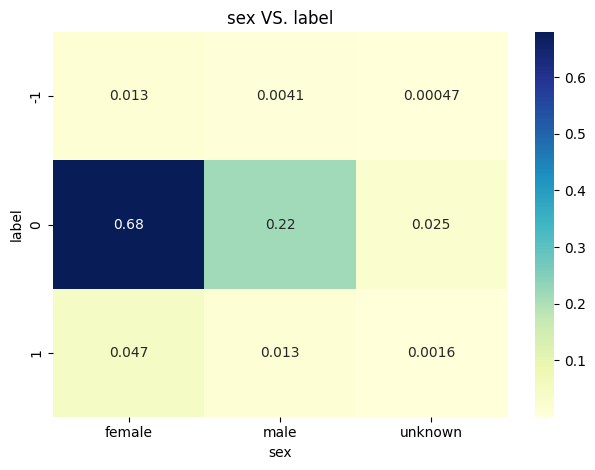

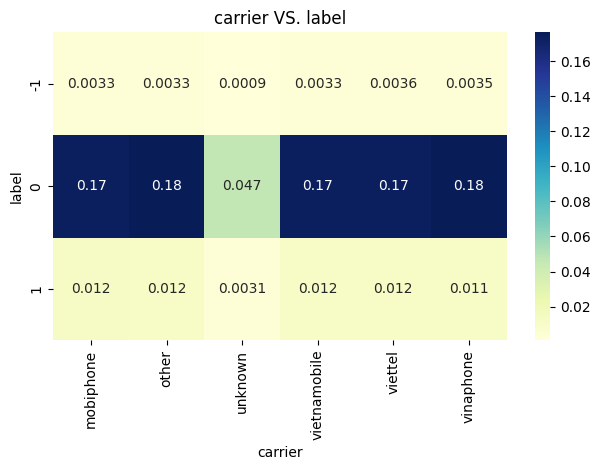

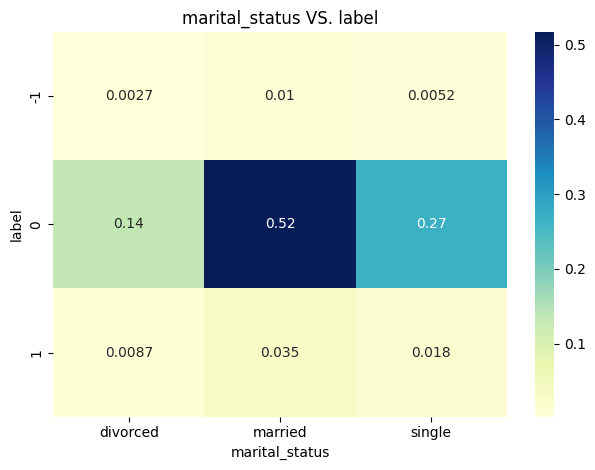

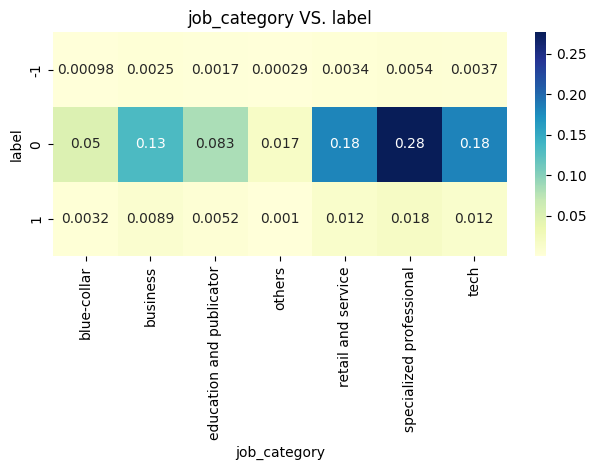

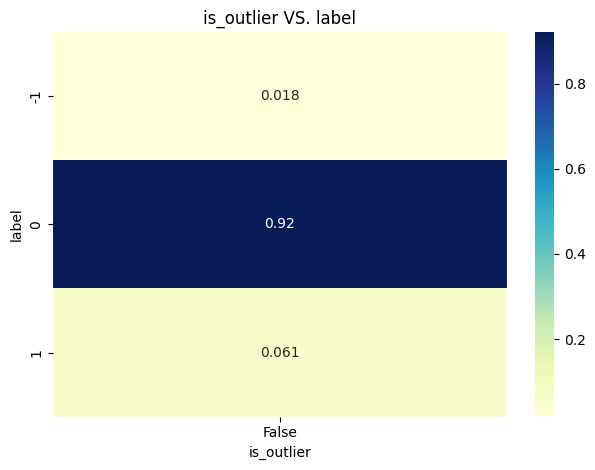

In [73]:
# Create contingency table
for col in user_info.columns:
    if col in ['user_id', 'age', 'label']:
        continue

    # Create contingency table
    ct = pd.crosstab(user_info['label'], user_info[col], normalize='all')
    
    # Plot heatmap
    # plt.figure(figsize=(12, 6))
    sns.heatmap(ct, annot=True, cmap='YlGnBu')
    plt.title(f'{col} VS. label')
    plt.tight_layout()
    save_fig(f'{col} VS. label')
    plt.show()  

    del ct # to free memory 

### Table `user_log`

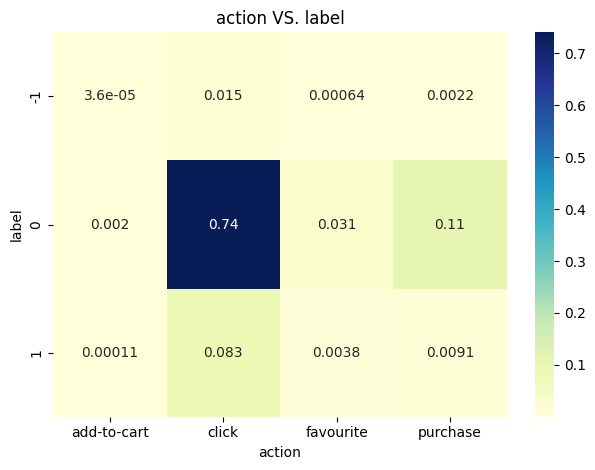

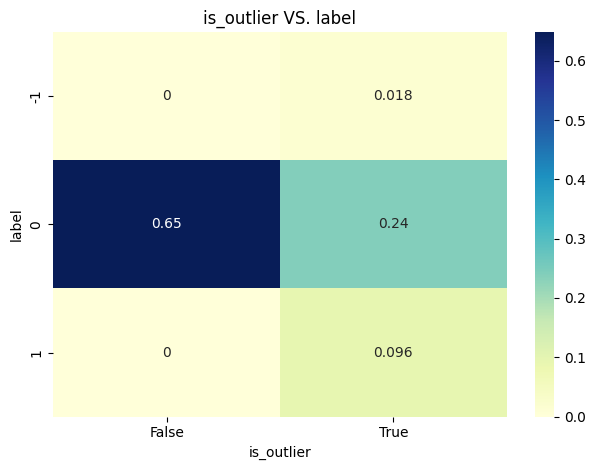

In [74]:
# Create contingency table
for col in user_log.columns:
    if col in ['user_id', 'item_id', 'cat_id', 'brand_id', 'merchant_id', 'datetime', 'label']:
        continue

    # Create contingency table
    ct = pd.crosstab(user_log['label'], user_log[col], normalize='all')
    
    # Plot heatmap
    # plt.figure(figsize=(12, 6))
    sns.heatmap(ct, annot=True, cmap='YlGnBu')
    plt.title(f'{col} VS. label')
    plt.tight_layout()
    save_fig(f'{col} VS. label')
    plt.show()   

    del ct    # to free momery 

## Seasonality 
- Detect behavior stability
- Detect shopping habits: Find if users tend to return and interact after fixed lags 


Daily Activity Overview
    datetime  total_actions  unique_users
0 2024-05-11             67            41
1 2024-05-12             44            33
2 2024-05-13             62            45
3 2024-05-14             63            39
4 2024-05-15             56            41


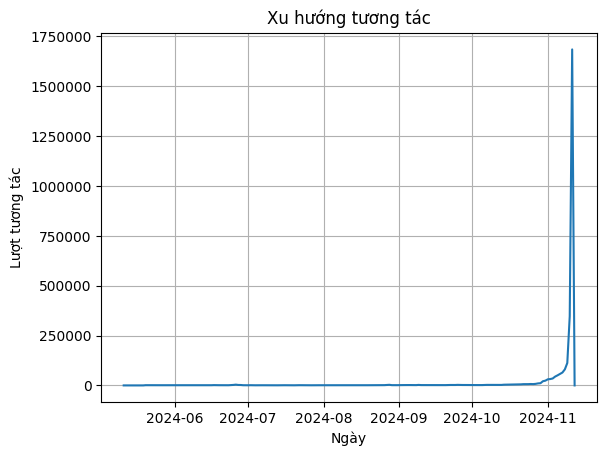

In [75]:
# Aggregate daily activity
daily_activity = user_log.groupby(user_log['datetime'].dt.date).agg(
    total_actions=('item_id', 'count'),
    unique_users=('user_id', 'nunique')
).reset_index()
daily_activity['datetime'] = pd.to_datetime(daily_activity['datetime'])

print('\nDaily Activity Overview')
print(daily_activity.head())

# plt.figure(figsize=(15, 6))
sns.lineplot(x='datetime', y='total_actions', data=daily_activity)
plt.title('Xu hướng tương tác')
plt.xlabel('Ngày')
plt.ylabel('Lượt tương tác')
plt.ticklabel_format(axis='y', style='plain')
plt.grid(True)
save_fig('Xu hướng tương tác')
plt.show()

In [76]:
# interaction counts are stable or drifting
result = adfuller(daily_activity['total_actions'])
print("p-value:", result[1])

if result[1] > 0.05:
    print("Không đủ bằng chứng để bác bỏ H0: Tương tác (click, thêm vào yêu thích, giỏ hàng, mua) hằng ngày không ổn định")
else:
    print("Bác bỏ H0: Tương tác (click, thêm vào yêu thích, giỏ hàng, mua) hằng ngày ổn định")

p-value: 0.9990389182564553
Không đủ bằng chứng để bác bỏ H0: Tương tác (click, thêm vào yêu thích, giỏ hàng, mua) hằng ngày không ổn định


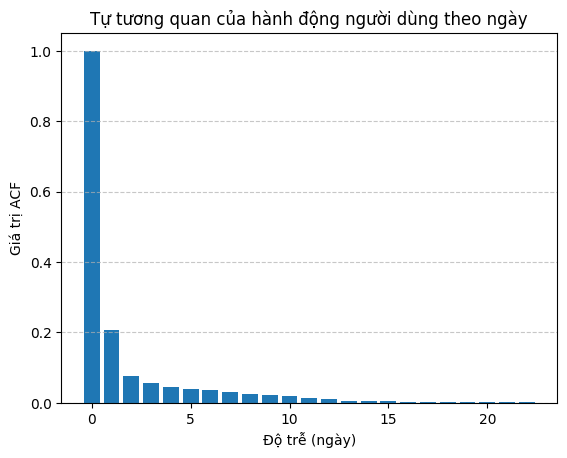

In [77]:
# find if users tend to return and interact after fixed lags 
acf_vals = acf(daily_activity['total_actions'])  
plt.bar(range(len(acf_vals)), acf_vals)          
plt.title('Tự tương quan của hành động người dùng theo ngày')  
plt.xlabel('Độ trễ (ngày)')                      
plt.ylabel('Giá trị ACF')                        
plt.grid(axis='y', linestyle='--', alpha=0.7)   
plt.xticks(range(0, len(acf_vals), 5))    
save_fig('Tự tương quan của hành động người dùng theo ngày')
plt.show()                                      


User Activity by Day of Week
   day_of_week  item_id  day_name
0            0  1776748   Thứ Hai
1            1   101852    Thứ Ba
2            2   120848    Thứ Tư
3            3   127637   Thứ Năm
4            4   149628   Thứ Sáu
5            5   180248   Thứ Bảy
6            6   420669  Chủ Nhật


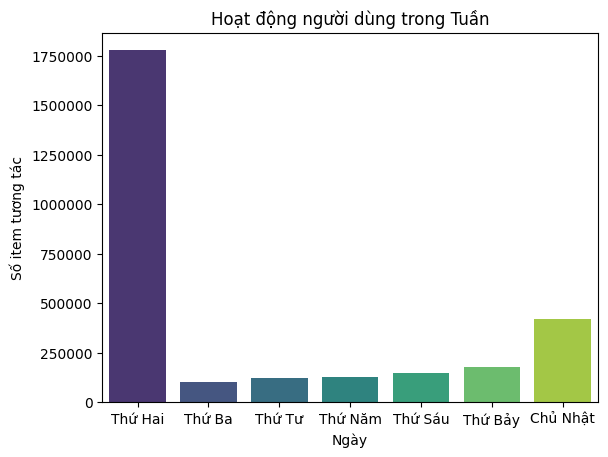

In [78]:
# Day of week 
user_log['day_of_week'] = user_log['datetime'].dt.dayofweek
activity_by_dayofweek = user_log.groupby('day_of_week')['item_id'].count().reset_index()
activity_by_dayofweek['day_name'] = activity_by_dayofweek['day_of_week'].map({
    0: 'Thứ Hai', 1: 'Thứ Ba', 2: 'Thứ Tư', 3: 'Thứ Năm', 4: 'Thứ Sáu', 5: 'Thứ Bảy', 6: 'Chủ Nhật'})
activity_by_dayofweek = activity_by_dayofweek.sort_values('day_of_week')

print('\nUser Activity by Day of Week')
print(activity_by_dayofweek)

# plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='item_id', data=activity_by_dayofweek, palette='viridis')
plt.title('Hoạt động người dùng trong Tuần')
plt.xlabel('Ngày')
plt.ylabel('Số item tương tác')
plt.ticklabel_format(axis='y', style='plain')
save_fig('Hoạt động người dùng trong Tuần')
plt.show()


User Activity by Month
   month  item_id
0      5    13381
1      6    36755
2      7    27018
3      8    35068
4      9    54477
5     10   171719
6     11  2539212


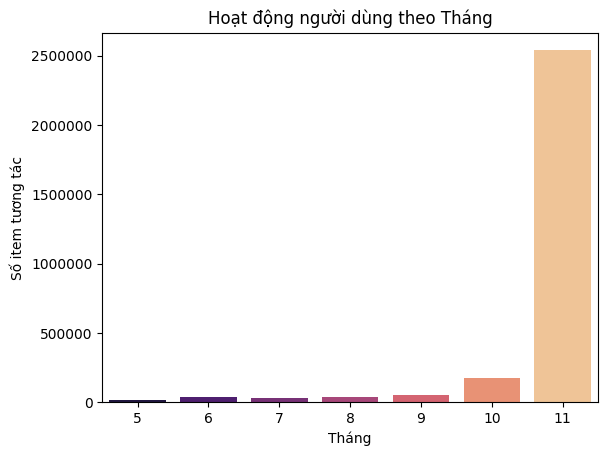

40937

In [79]:
# Month
user_log['month'] = user_log['datetime'].dt.month
activity_by_month = user_log.groupby('month')['item_id'].count().reset_index()

print('\nUser Activity by Month')
print(activity_by_month)

# plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='item_id', data=activity_by_month, palette='magma')
plt.title('Hoạt động người dùng theo Tháng')
plt.xlabel('Tháng')
plt.ylabel('Số item tương tác')
plt.ticklabel_format(axis='y', style='plain')
save_fig('Hoạt động người dùng theo Tháng')
plt.show()

del user_log['day_of_week'], activity_by_dayofweek, acf_vals, daily_activity, activity_by_month, user_log['month']    # to free memory
gc.collect()

## User logs before purchasing

In [80]:
# item action count
item = pd.DataFrame()
item = user_log[user_log['action'] == 'add-to-cart'].groupby('item_id').size().reset_index(name='add-to-cart')
item = pd.merge(item, user_log[user_log['action'] == 'favourite'].groupby('item_id').size().reset_index(name='favorite'), on='item_id')
item = pd.merge(item, user_log[user_log['action'] == 'purchase'].groupby('item_id').size().reset_index(name='purchase'), on='item_id')
item = pd.merge(item, user_log[user_log['action'] == 'click'].groupby('item_id').size().reset_index(name='click'), on='item_id')

# category action count
cat = pd.DataFrame()
cat = user_log[user_log['action'] == 'add-to-cart'].groupby('cat_id').size().reset_index(name='add-to-cart')
cat = pd.merge(cat, user_log[user_log['action'] == 'favourite'].groupby('cat_id').size().reset_index(name='favorite'), on='cat_id')
cat = pd.merge(cat, user_log[user_log['action'] == 'purchase'].groupby('cat_id').size().reset_index(name='purchase'), on='cat_id')
cat = pd.merge(cat, user_log[user_log['action'] == 'click'].groupby('cat_id').size().reset_index(name='click'), on='cat_id')

# brand action count
brand = pd.DataFrame()
brand = user_log[user_log['action'] == 'add-to-cart'].groupby('brand_id').size().reset_index(name='add-to-cart')
brand = pd.merge(brand, user_log[user_log['action'] == 'favourite'].groupby('brand_id').size().reset_index(name='favorite'), on='brand_id')
brand = pd.merge(brand, user_log[user_log['action'] == 'purchase'].groupby('brand_id').size().reset_index(name='purchase'), on='brand_id')
brand = pd.merge(brand, user_log[user_log['action'] == 'click'].groupby('brand_id').size().reset_index(name='click'), on='brand_id')

# merchant action count
merchant = pd.DataFrame()
merchant = user_log[user_log['action'] == 'add-to-cart'].groupby('merchant_id').size().reset_index(name='add-to-cart')
merchant = pd.merge(merchant, user_log[user_log['action'] == 'favourite'].groupby('merchant_id').size().reset_index(name='favorite'), on='merchant_id')
merchant = pd.merge(merchant, user_log[user_log['action'] == 'purchase'].groupby('merchant_id').size().reset_index(name='purchase'), on='merchant_id')
merchant = pd.merge(merchant, user_log[user_log['action'] == 'click'].groupby('merchant_id').size().reset_index(name='click'), on='merchant_id')

# sum action counts for each group
item_sum = item[['add-to-cart', 'favorite', 'purchase', 'click']].sum()
cat_sum = cat[['add-to-cart', 'favorite', 'purchase', 'click']].sum()
brand_sum = brand[['add-to-cart', 'favorite', 'purchase', 'click']].sum()
merchant_sum = merchant[['add-to-cart', 'favorite', 'purchase', 'click']].sum()

# combine into one DataFrame
data = pd.DataFrame({
    'Item': item_sum,
    'Category': cat_sum,
    'Brand': brand_sum,
    'Merchant': merchant_sum
}).T  

print(data.head())

          add-to-cart  favorite  purchase    click
Item             4635     28409    116133   639047
Category         5994     95697    319353  2245358
Brand            3822     37928    100412   807693
Merchant         6127     93942    304414  2170862


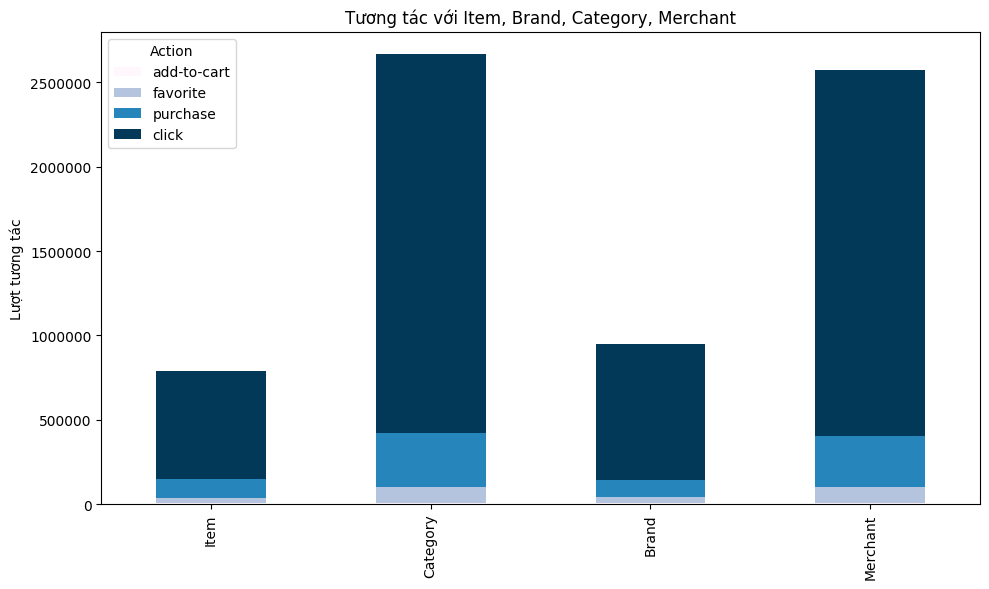

In [81]:
# visualize count of actions

data.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='PuBu')
plt.title('Tương tác với Item, Brand, Category, Merchant')
plt.ylabel('Lượt tương tác')
plt.legend(title='Action')
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
save_fig('Tương tác với Item, Brand, Category, Merchant')
plt.show()

In [82]:
funnel = user_log['action'].value_counts()
clicks = funnel.get('click', 0)
purchases = funnel.get('purchase', 0)
add_to_cart = funnel.get('add-to-cart', 0)

funnel_rate = {
    'Click → Add to Cart': add_to_cart / clicks if clicks else 0,
    'Add to Cart → Purchase': purchases / add_to_cart if add_to_cart else 0,
    'Click → Purchase': purchases / clicks if clicks else 0
}

print("Funnel chuyển đổi tổng thể:")
for step, rate in funnel_rate.items():
    print(f"{step}: {rate:.4%}")

# explain for Add to Cart → Purchase > 100%:    
# this platform may allow users to purchase directly without adding items to cart

Funnel chuyển đổi tổng thể:
Click → Add to Cart: 0.2542%
Add to Cart → Purchase: 5806.9635%
Click → Purchase: 14.7591%


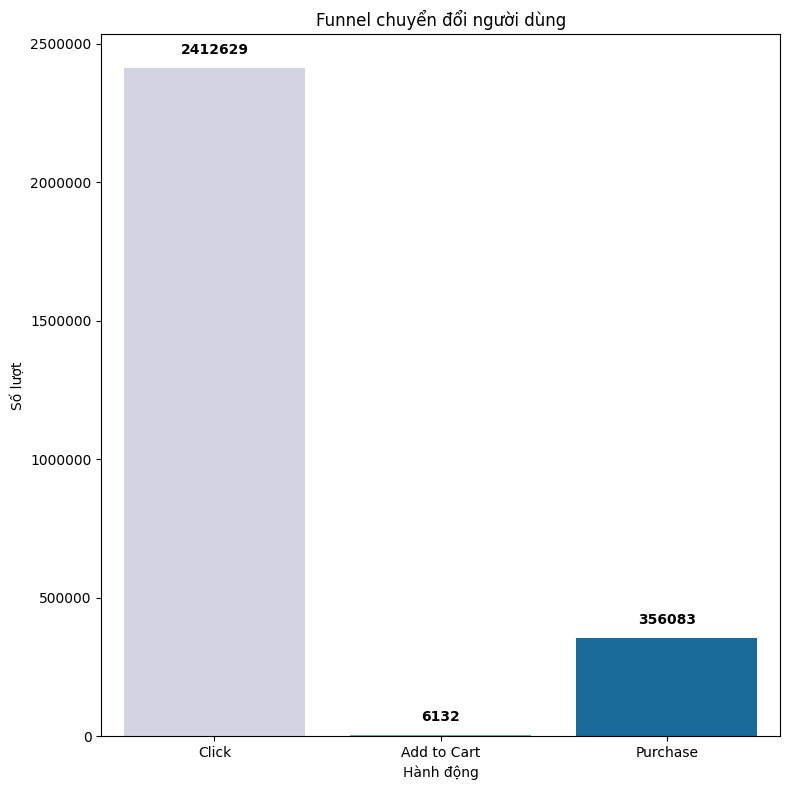

In [83]:
stages = ['Click', 'Add to Cart', 'Purchase']
counts = [clicks, add_to_cart, purchases]

plt.figure(figsize=(8,8))
sns.barplot(x=stages, y=counts, palette='PuBu')
plt.title("Funnel chuyển đổi người dùng")
plt.ylabel("Số lượt")
plt.xlabel("Hành động")
plt.ticklabel_format(axis='y', style='plain')
for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.02, str(v), ha='center', fontweight='bold')
plt.tight_layout()
save_fig("Funnel chuyển đổi người dùng")
plt.show()

In [84]:
# Filter click and purchase actions
clicks = user_log[user_log['action'] == 'click']
purchases = user_log[user_log['action'] == 'purchase']

# Count clicks per (user, item)
click_counts = clicks.groupby(['item_id']).size().reset_index(name='click_count')

# Count purchases per (user, item)
purchase_counts = purchases.groupby(['item_id']).size().reset_index(name='purchase_count')

# Merge the two counts together
purchase_after_click = pd.merge(click_counts, purchase_counts, on=['item_id'], how='outer').fillna(0)

# Convert float to int
purchase_after_click['click_count'] = purchase_after_click['click_count'].astype(int)
purchase_after_click['purchase_count'] = purchase_after_click['purchase_count'].astype(int)

print(purchase_after_click.head())

   item_id  click_count  purchase_count
0        8           10               3
1       28            2               0
2       30            1               0
3       47            4               0
4       60            9               1


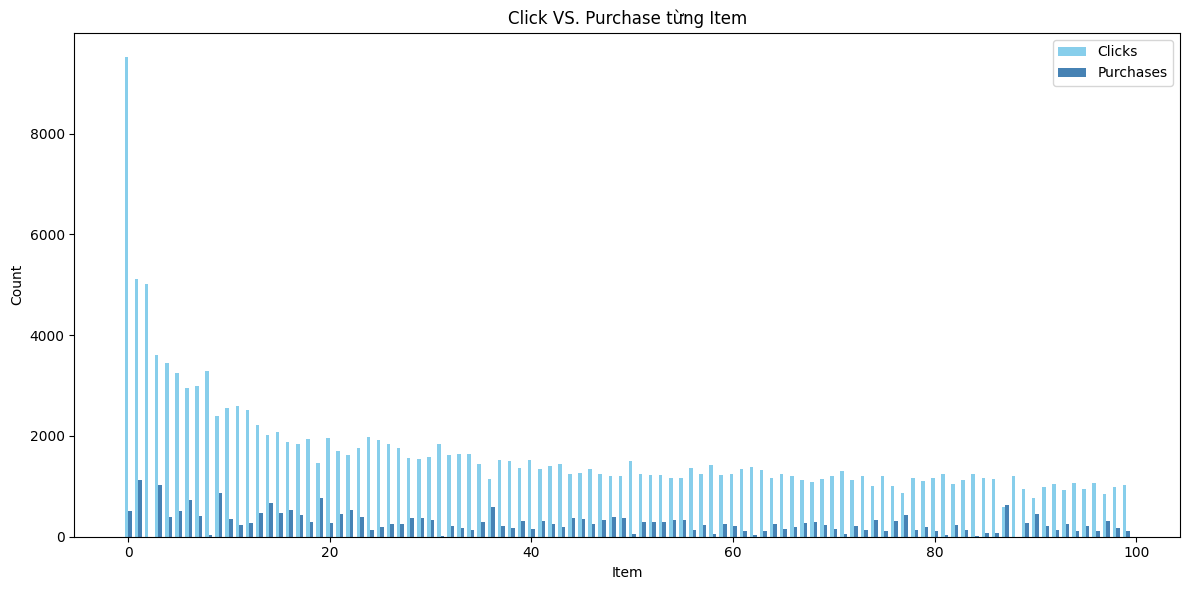

In [85]:
# click and purchase of every item 
# visualization by grouped bar chart 

# select top 100 users by total activity (click + purchase)
top_n = 100 
purchase_after_click['total'] = purchase_after_click['click_count'] + purchase_after_click['purchase_count']
top_items = purchase_after_click.sort_values('total', ascending=False).head(top_n)

# Bar positions
x = np.arange(len(top_items))  # positions for each item 
width = 0.35  # width of each bar

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, top_items['click_count'], width, label='Clicks', color='skyblue')
bars2 = ax.bar(x + width/2, top_items['purchase_count'], width, label='Purchases', color='steelblue')

# Labels and titles
ax.set_xlabel('Item')
ax.set_ylabel('Count')
ax.set_title('Click VS. Purchase từng Item')
#ax.set_xticks(x)
ax.legend()
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
save_fig('Click VS. Purchase từng Item')
plt.show()


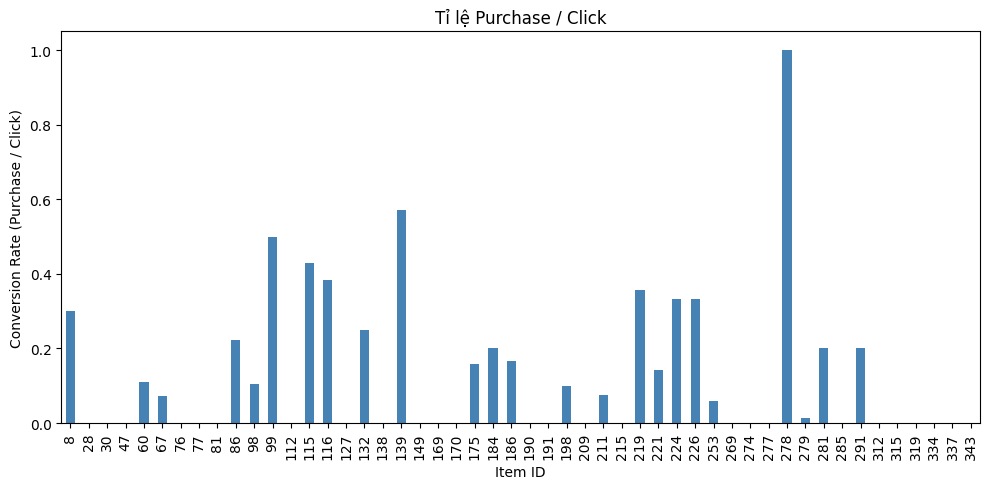

In [86]:
# click to purchase rate 
conversion_rate = (purchases.groupby('item_id').size() / clicks.groupby('item_id').size())[:50]

# Plot line chart
plt.figure(figsize=(10, 5))
conversion_rate.plot(kind='bar', color='steelblue')
plt.xlabel('Item ID')
plt.ylabel('Conversion Rate (Purchase / Click)')
plt.title('Tỉ lệ Purchase / Click')
plt.tight_layout()
save_fig('Tỉ lệ Purchase-Click')
plt.show()

In [87]:
del item_sum, brand_sum, cat_sum, merchant_sum, data, funnel, clicks, purchases,purchase_after_click, conversion_rate   # to free memory 
gc.collect()

16316

# Churn probability

## Feature Selection
- Feature relevance: Mutual information, Correlation  

In [88]:
# create a dataframe to store count of actions and information of every user
separate_user_log = pd.DataFrame()
# count add to cart per user 
separate_user_log = user_log[user_log['action'] == 'add-to-cart'].groupby(['user_id', 'merchant_id']).size().reset_index(name='add-to-cart')
# count favourite per user 
separate_user_log = pd.merge(separate_user_log, user_log[user_log['action'] == 'favourite'].groupby(['user_id', 'merchant_id']).size().reset_index(name='favorite'), on=['user_id', 'merchant_id'], how='outer')
# count purchase per user 
separate_user_log = pd.merge(separate_user_log, user_log[user_log['action'] == 'purchase'].groupby(['user_id', 'merchant_id']).size().reset_index(name='purchase'), on=['user_id', 'merchant_id'], how='outer')
# count click per user 
separate_user_log = pd.merge(separate_user_log, user_log[user_log['action'] == 'click'].groupby(['user_id', 'merchant_id']).size().reset_index(name='click'), on=['user_id', 'merchant_id'], how='outer')
# add label 
separate_user_log = pd.merge(separate_user_log, user_log[['user_id', 'label', 'merchant_id']], on=['user_id', 'merchant_id'], how='left')
# add user information 
separate_user_log = pd.merge(separate_user_log, user_info.drop(columns=['label', 'is_outlier']), on='user_id', how='left')
encoder = LabelEncoder()
encoded_separate_user_log = separate_user_log.copy()
cat_columns = ['sex', 'carrier', 'marital_status', 'job_category']
for col in cat_columns:
    encoded_separate_user_log[col] = encoder.fit_transform(separate_user_log[col])

In [89]:
separate_user_log.isna().sum() 

user_id                 0
merchant_id             0
add-to-cart       4330964
favorite          2883862
purchase                0
click               69368
label                   0
age                    98
sex                    98
carrier                98
marital_status         98
job_category           98
dtype: int64

In [90]:
separate_user_log = separate_user_log.fillna(0)
encoded_separate_user_log = encoded_separate_user_log.fillna(0)

In [91]:
encoded_X = encoded_separate_user_log.drop(columns='label')
y = encoded_separate_user_log['label']
feature_names = encoded_separate_user_log.columns.difference(['label'])

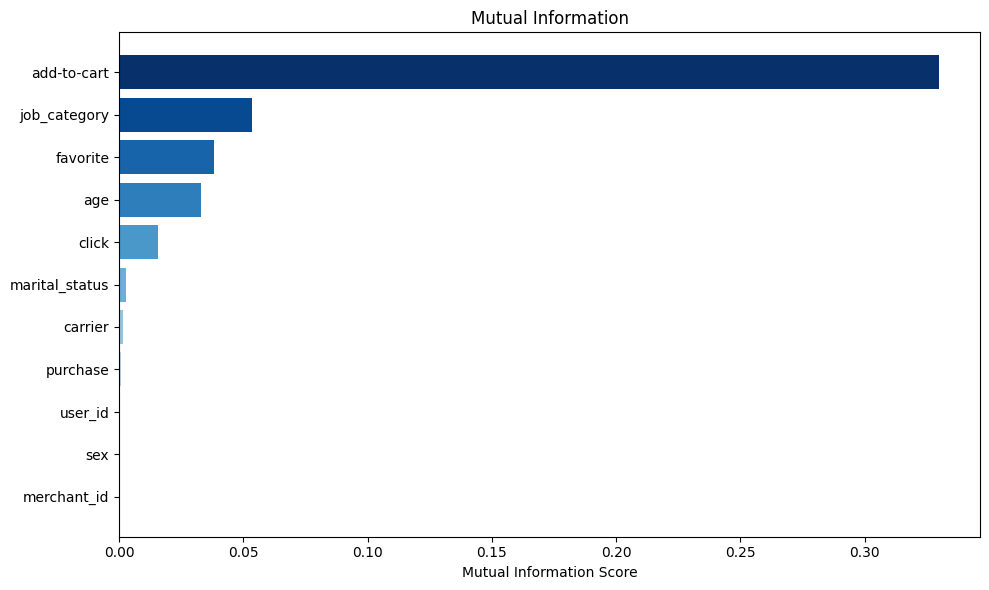

In [92]:
# Compute MI
mi_matrix = mutual_info_regression(encoded_X, y)
mi_matrix = np.array(mi_matrix)

# Sort features by MI
sorted_indices = np.argsort(mi_matrix)[::-1]
sorted_mi = mi_matrix[sorted_indices]
sorted_features = feature_names[sorted_indices]

# Generate dark to light blue colors using 'Blues_r'
colors = plt.cm.Blues_r(np.linspace(0, 1, len(sorted_features)))  # dark to light

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_mi, color=colors)
plt.xlabel('Mutual Information Score')
plt.title('Mutual Information')
plt.gca().invert_yaxis()  # Highest score at top
plt.tight_layout()
save_fig('Mutual Information')
plt.show()

label             1.000000
click             0.114474
favorite          0.021922
age               0.020687
merchant_id       0.009545
marital_status    0.008198
user_id           0.006431
sex              -0.004524
purchase         -0.005010
carrier          -0.006918
job_category     -0.009809
add-to-cart      -0.018194
Name: label, dtype: float64


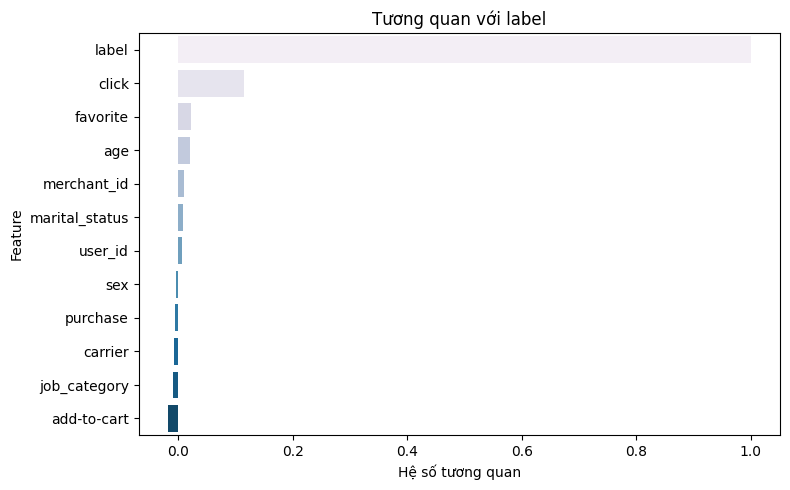

In [93]:
# Tính Pearson correlation
correlation_matrix = encoded_separate_user_log.corr()

# Hiển thị tương quan của từng feature với target
correlation_with_target = correlation_matrix['label'].sort_values(ascending=False)
print(correlation_with_target)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=correlation_with_target.values,
    y=correlation_with_target.index,
    palette='PuBu'
)
plt.title("Tương quan với label")
plt.xlabel("Hệ số tương quan")
plt.ylabel("Feature")
plt.tight_layout()
save_fig("Tương quan với label")
plt.show()


In [94]:
del correlation_matrix, sorted_features, sorted_mi, sorted_indices, mi_matrix
gc.collect()

4659

In [95]:
selected_features = ['add-to-cart', 'job_category', 'favorite', 'age', 'click']
X = separate_user_log[selected_features]

## CatBoost

In [96]:
# tuning hyperparameters 
NUM_ITERATIONS = 5
SAMPLE_SIZE = 100_000  
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.03, 0.05],
    'depth': [4, 6],
    'l2_leaf_reg': [3, 6, 9],
    'bagging_temperature': [0.5, 1, 2],
    'random_strength': [3, 5]
}

best_models = []
best_scores = []
categorical_cols = ['job_category']

for i in range(NUM_ITERATIONS):
    print(f"\n--- Iteration {i+1}/{NUM_ITERATIONS} ---")
    
    # random sample a chunk from full data
    indices = np.random.choice(len(X), size=SAMPLE_SIZE, replace=False)
    X_sample = X.iloc[indices].copy()
    y_sample = y.iloc[indices].copy()

    # train/val split
    X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

    # tune CatBoostRegressor 
    model = CatBoostRegressor(verbose=0)
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=10,
        scoring='neg_root_mean_squared_error',
        cv=3,
        n_jobs=-1,
    )
    search.fit(
        X_train, y_train,
        **{'cat_features': categorical_cols,
        'eval_set': (X_val, y_val),
        'early_stopping_rounds': 50
        }
    )

    best_model = search.best_estimator_
    best_models.append(best_model)

    # evaluate on validation set
    y_pred = best_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)  # RMSE
    best_scores.append(rmse)

    print(f"Best RMSE on validation: {rmse:.4f}")
    print(f"Best parameters: {search.best_params_}")

# summary of results
print("\n===== Final Summary =====")
for i, score in enumerate(best_scores):
    print(f"Iteration {i+1}: RMSE = {score:.4f}")


--- Iteration 1/5 ---
Best RMSE on validation: 0.3245
Best parameters: {'random_strength': 3, 'learning_rate': 0.05, 'l2_leaf_reg': 6, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 0.5}

--- Iteration 2/5 ---
Best RMSE on validation: 0.3271
Best parameters: {'random_strength': 3, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 2}

--- Iteration 3/5 ---
Best RMSE on validation: 0.3305
Best parameters: {'random_strength': 5, 'learning_rate': 0.05, 'l2_leaf_reg': 6, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 2}

--- Iteration 4/5 ---
Best RMSE on validation: 0.3252
Best parameters: {'random_strength': 3, 'learning_rate': 0.05, 'l2_leaf_reg': 9, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 2}

--- Iteration 5/5 ---
Best RMSE on validation: 0.3294
Best parameters: {'random_strength': 3, 'learning_rate': 0.03, 'l2_leaf_reg': 6, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 1}

===== Final Summary =====
I

In [97]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
y_pred = best_model.predict(X_val)

In [98]:
mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
med_ae = median_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)
max_err = max_error(y_val, y_pred)

print(f"Mean Squared Error (MSE):           {mse:.4f}")
print(f"Root Mean Squared Error (RMSE):     {rmse:.4f}")
print(f"Mean Absolute Error (MAE):          {mae:.4f}")
print(f"Median Absolute Error:              {med_ae:.4f}")
print(f"Mean Absolute Percentage Error:     {mape*100:.2f}%")
print(f"Maximum Error:                      {max_err:.4f}")
print(f"Hệ số xác định (R²):                {r2:.4f}")

Mean Squared Error (MSE):           0.1075
Root Mean Squared Error (RMSE):     0.3279
Mean Absolute Error (MAE):          0.1648
Median Absolute Error:              0.0581
Mean Absolute Percentage Error:     24784950886469896.00%
Maximum Error:                      1.4066
Hệ số xác định (R²):                0.0950


In [99]:
# Predict on the whole dataset
separate_user_log['CatBoost Prob.'] = best_model.predict(X).round(2)

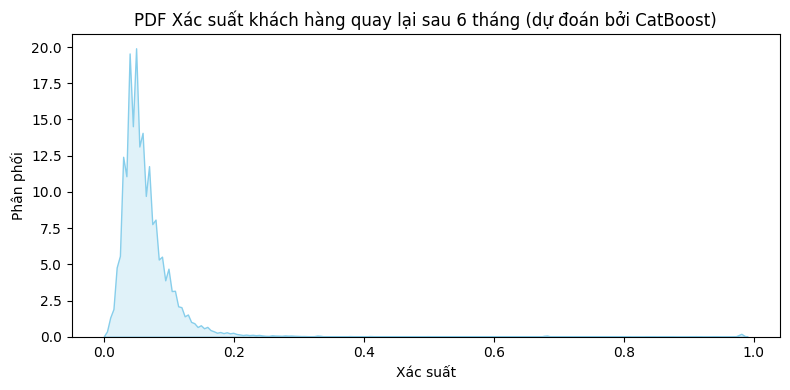

In [100]:
plt.figure(figsize=(8, 4))
sns.kdeplot(separate_user_log[separate_user_log['CatBoost Prob.']>0]['CatBoost Prob.'], fill=True, color='skyblue')
plt.title('PDF Xác suất khách hàng quay lại sau 6 tháng (dự đoán bởi CatBoost)')
plt.xlabel('Xác suất')
plt.ylabel('Phân phối')
plt.tight_layout()
plt.ticklabel_format(axis='y', style='plain')
save_fig('PDF Xác suất khách hàng quay lại sau 6 tháng (dự đoán bởi CatBoost)')
plt.show()

In [101]:
del best_models, best_scores, encoded_separate_user_log, user_info
gc.collect()

157

# Profiling 

In [102]:
loyal_customers = separate_user_log[separate_user_log['label']==1]
deal_hunters = separate_user_log[separate_user_log['label']==0]

Skipping 'user_id' (too many unique values: 15791)
Skipping 'merchant_id' (too many unique values: 1649)


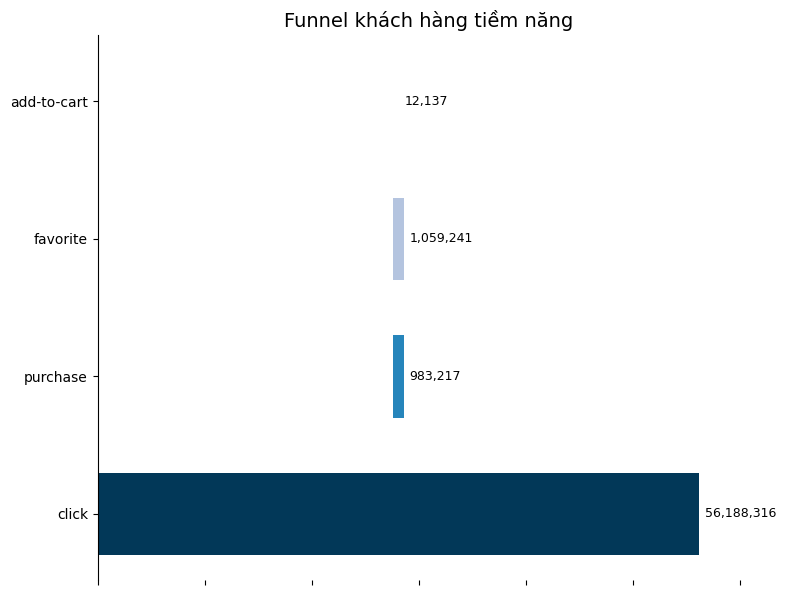

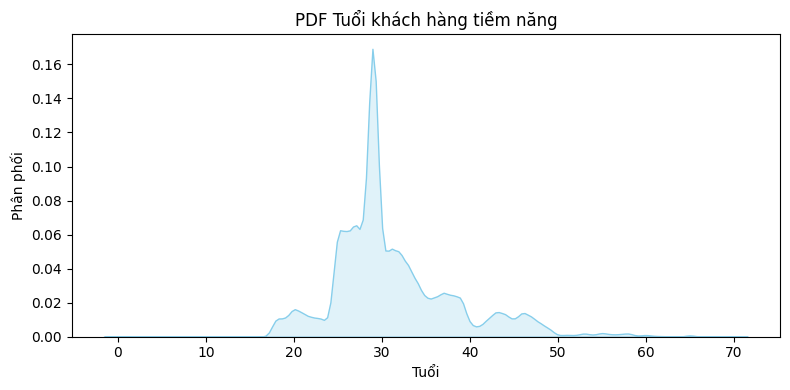

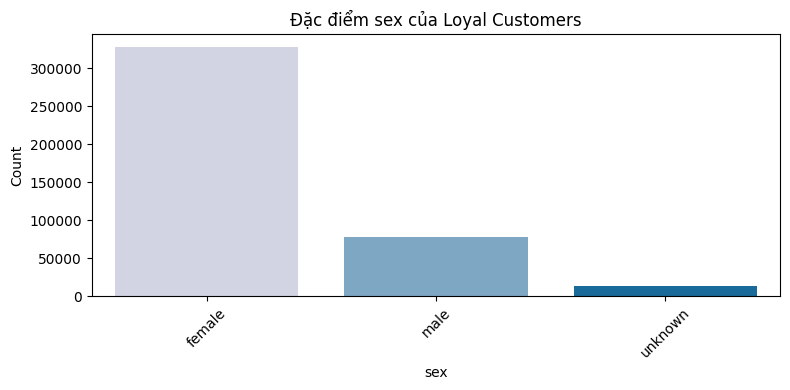

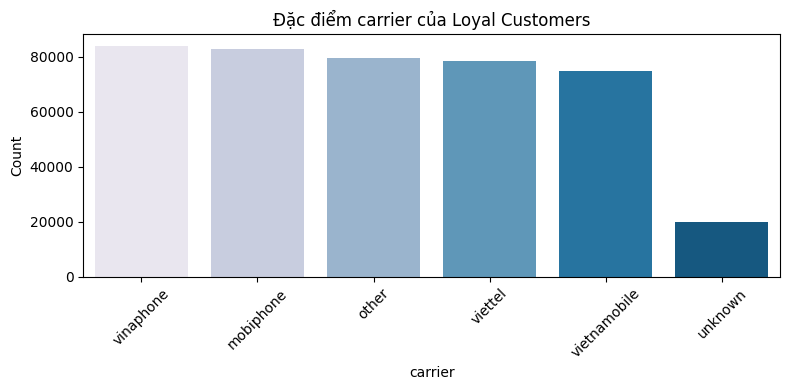

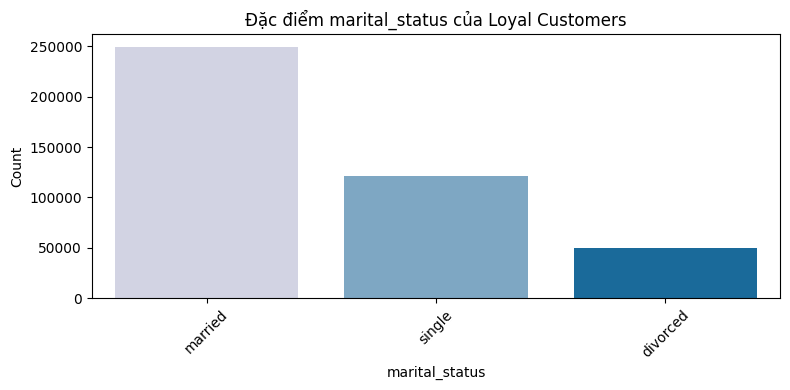

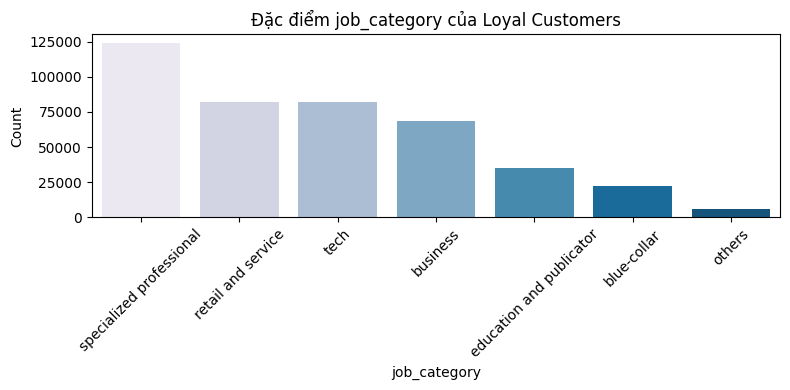

In [103]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
max_unique = 10

for col in loyal_customers.columns:
    # pass out non-demographic information 
    if col in ['label', 'CatBoost Prob.','favorite', 'purchase', 'click']:
        continue
    # create a funnel of actions 
    elif col == 'add-to-cart':
        # Funnel stages and values
        stages = ['add-to-cart', 'favorite', 'purchase', 'click']
        values = [loyal_customers[stage].sum() for stage in stages]
        
        # Compute bar positions for centering
        n = len(stages)
        cmap = cm.get_cmap('PuBu', n)
        colors = [cmap(i) for i in range(n)]
        max_value = max(values)
        left_offsets = [(max_value - v) / 2 for v in values]
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        
        for i, (stage, value, offset) in enumerate(zip(stages, values, left_offsets)):
            ax.barh(y=i, width=value, left=offset, height=0.6, color=colors[i])
            
            # Add value label at the end of each bar
            ax.text(offset + value + max_value * 0.01, i, f'{int(value):,}', 
                    va='center', ha='left', fontsize=9)
        
        # Set Y ticks and labels
        ax.set_yticks(range(len(stages)))
        ax.set_yticklabels(stages)
        
        # Clean up axes
        ax.invert_yaxis()  # the first stage is on top
        ax.set_xlim(0, max_value * 1.1)  # xtend to fit text
        ax.set_xticklabels('')
        
        # styling
        ax.set_title('Funnel khách hàng tiềm năng', fontsize=14)
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
        plt.tight_layout()
        plt.show()
                
    # PDF for age (continuous values)
    elif col == 'age':
        plt.figure(figsize=(8, 4))
        sns.kdeplot(loyal_customers['age'], fill=True, color='skyblue')
        plt.title('PDF Tuổi khách hàng tiềm năng')
        plt.xlabel('Tuổi')
        plt.ylabel('Phân phối')
        plt.tight_layout()
        plt.ticklabel_format(axis='y', style='plain')
        plt.show()

    # countplot for the lefts  
    elif loyal_customers[col].nunique() <= max_unique:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=loyal_customers[col].value_counts().index, 
            y=loyal_customers[col].value_counts().values, 
            palette=sns.color_palette("PuBu", n_colors=loyal_customers[col].nunique()))
        plt.title(f'Đặc điểm {col} của Loyal Customers')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        save_fig(f'Đặc điểm {col} của Loyal Customers')
        plt.show()
    else:
        print(f"Skipping '{col}' (too many unique values: {loyal_customers[col].nunique()})")

Skipping 'user_id' (too many unique values: 201152)
Skipping 'merchant_id' (too many unique values: 1993)


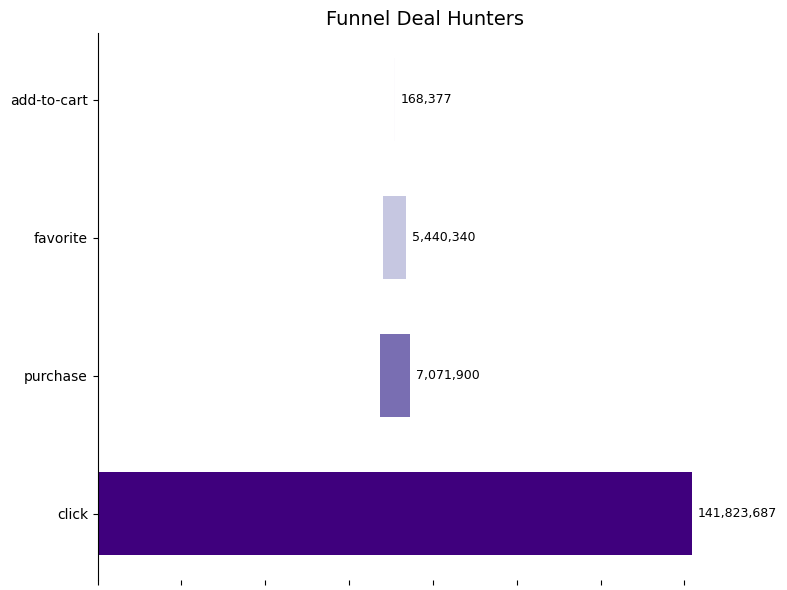

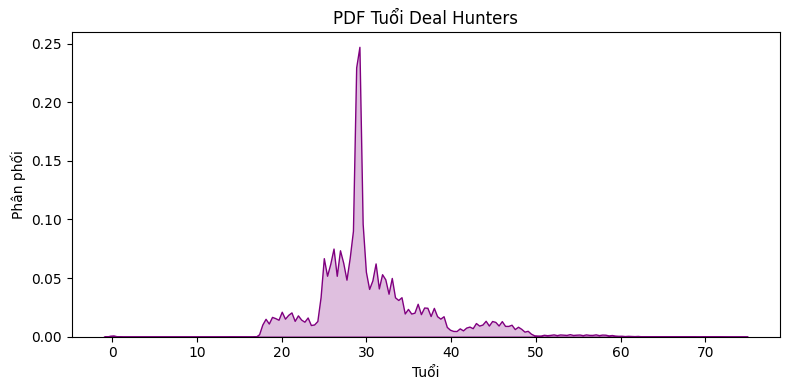

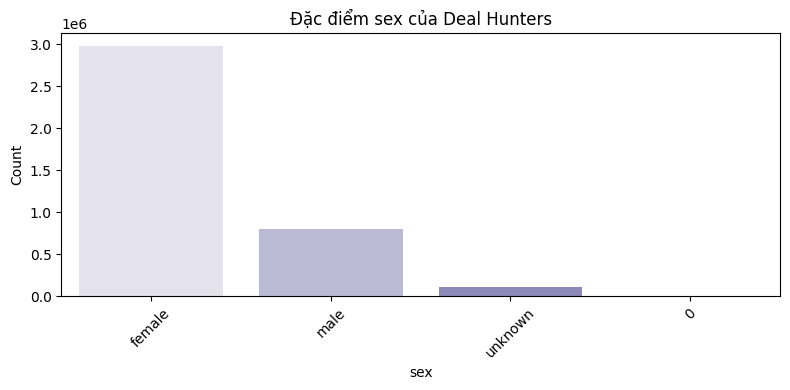

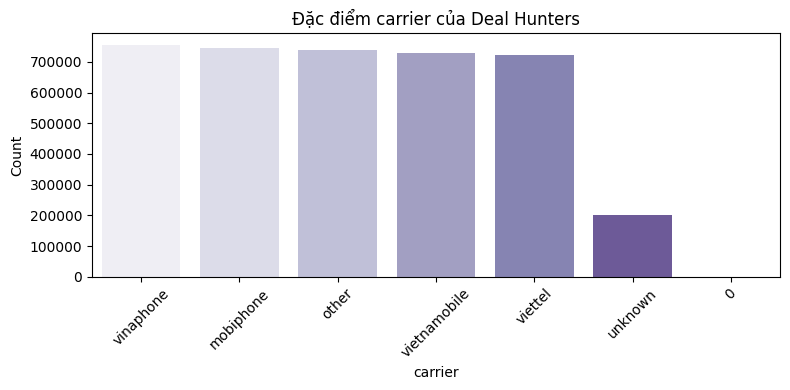

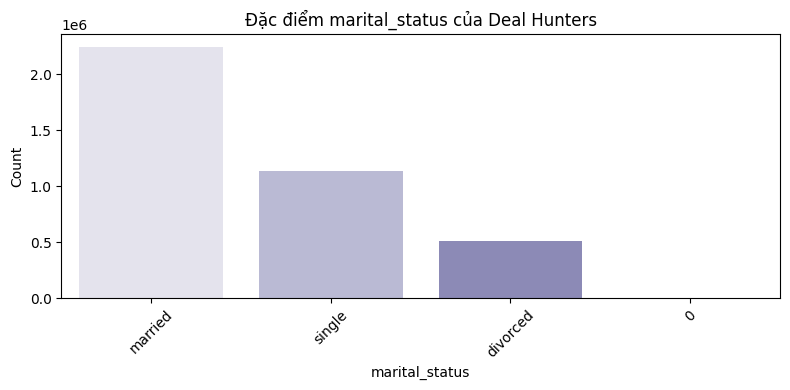

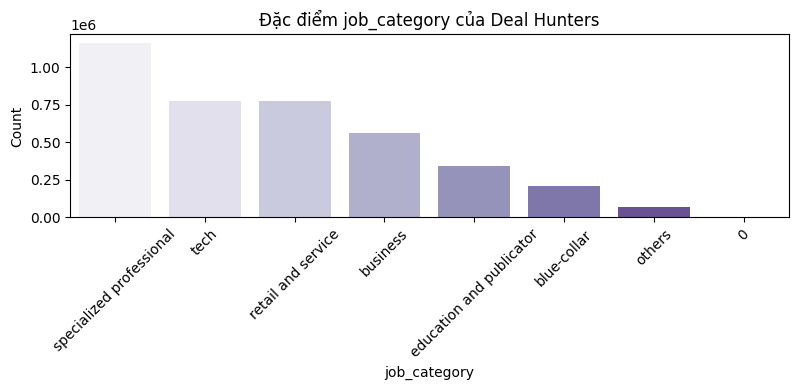

In [105]:
max_unique = 10

for col in deal_hunters.columns:
    # pass out non-demographic information 
    if col in ['label', 'CatBoost Prob.','favorite', 'purchase', 'click']:
        continue

    # create a funnel of actions 
    elif col == 'add-to-cart':
        # Funnel stages and values
        stages = ['add-to-cart', 'favorite', 'purchase', 'click']
        values = [deal_hunters[stage].sum() for stage in stages]
        
        # Compute bar positions for centering
        n = len(stages)
        cmap = cm.get_cmap('Purples', n)
        colors = [cmap(i) for i in range(n)]
        max_value = max(values)
        left_offsets = [(max_value - v) / 2 for v in values]
        
        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        
        for i, (stage, value, offset) in enumerate(zip(stages, values, left_offsets)):
            ax.barh(y=i, width=value, left=offset, height=0.6, color=colors[i])
            
            # 🔽 Add value label at the end of each bar
            ax.text(offset + value + max_value * 0.01, i, f'{int(value):,}', 
                    va='center', ha='left', fontsize=9)
        
        # Set Y ticks and labels
        ax.set_yticks(range(len(stages)))
        ax.set_yticklabels(stages)
        
        # Clean up axes
        ax.invert_yaxis()  # So the first stage is on top
        ax.set_xlim(0, max_value * 1.1)  # Extend a bit to fit text
        ax.set_xticklabels('')
        
        # Optional styling
        ax.set_title('Funnel Deal Hunters', fontsize=14)
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
        plt.tight_layout()
        plt.show()
                
    # PDF for age (continuous values)
    elif col == 'age':
        plt.figure(figsize=(8, 4))
        sns.kdeplot(deal_hunters['age'], fill=True, color='purple')
        plt.title('PDF Tuổi Deal Hunters')
        plt.xlabel('Tuổi')
        plt.ylabel('Phân phối')
        plt.tight_layout()
        plt.ticklabel_format(axis='y', style='plain')
        plt.show()

    # countplot for the lefts  
    elif deal_hunters[col].nunique() <= max_unique:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=deal_hunters[col].value_counts().index, 
            y=deal_hunters[col].value_counts().values, 
            palette=sns.color_palette("Purples", n_colors=deal_hunters[col].nunique()))
        plt.title(f'Đặc điểm {col} của Deal Hunters')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping '{col}' (too many unique values: {deal_hunters[col].nunique()})")